In [1]:
import itertools

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor,ExtraTreesClassifier,RandomForestClassifier
from sklearn.preprocessing import StandardScaler,KBinsDiscretizer,LabelEncoder,MinMaxScaler
from sklearn.metrics import mean_squared_error,f1_score
from sklearn.kernel_approximation import Nystroem
from sklearn.neighbors import KNeighborsClassifier

from catboost import Pool, cv,CatBoostClassifier,CatBoostRegressor

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, concatenate,Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import regularizers
import tensorflow_addons as tfa

from tqdm import tqdm

import lightgbm as lgb

from imblearn.over_sampling import RandomOverSampler,SMOTE, ADASYN

In [2]:
train_df = pd.read_csv('train_df_final_blanced.csv')
train_df = train_df.fillna(0)
train_df_org = pd.read_csv('train_df_final.csv')
train_df_org = train_df_org.fillna(0)
test_df = pd.read_csv('test_df_final.csv')
test_df = test_df.fillna(0)
submission_df = pd.read_csv('sample_submission.csv')

In [3]:
y = train_df['label'].values
y_org = train_df_org['label'].values

In [4]:
y.sum()/y.shape[0]

0.8888952852455242

In [5]:
model_predictions_train = pd.DataFrame()
model_predictions_train['label'] = train_df['label']
model_predictions_test = pd.DataFrame()

In [6]:
for column in train_df.columns:
    print(column)

additional_fare
duration
meter_waiting
meter_waiting_fare
meter_waiting_till_pickup
fare
pickup_date
pickup_hour
pickup_minute
drop_date
drop_hour
drop_minute
pick_cluster
is_more_than_one_day
distance_km
fare_per_km
pickup_timeslot
day_of_week
is_weekday
cal_time_difference
label
predicted_fare
predicted_fare_diff
predicted_fare_diff_per_fare
predicted_fare_diff_per_predicted_fare
fare_per_distance
predicted_fare_per_distance
predicted_fare_diff_per_distance
predicted_duration
predicted_duration_diff
predicted_duraton_diff_per_duraton
predicted_duraton_diff_per_predicted_duration
predicted_duraton_diff_per_distance
fare_per_duration
predicted_fare_per_duration
predicted_fare_per_duration_diff
avg_speed
predicted_avg_speed
predicted_avg_speed_diff
predicted_meter_waiting
predicted_meter_waiting_diff
predicted_meter_waiting_diff_per_meter_waiting
predicted_meter_waiting_diff_per_distance
predicted_meter_waiting_diff_per_predicted_meter_waiting
meter_waiting_per_duration
predicted_meter_

## Anomaly based

In [7]:
features = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

cat_features = [
    'fare_anomaly',
    'additional_fare_anomaly', 
    'duration_anomaly',
    'meter_waiting_anomaly', 
    'meter_waiting_fare_anomaly',
    'meter_waiting_till_pickup_anomaly', 
    'additional_fare_duration_anomaly',
    'additional_fare_meter_waiting_anomaly',
    'additional_fare_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_anomaly', 
    'duration_meter_waiting_fare_anomaly',
    'duration_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_anomaly',
    'meter_waiting_meter_waiting_till_pickup_anomaly',
    'meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_anomaly',
    'additional_fare_duration_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_anomaly',
    'duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_fare_anomaly',
    'additional_fare_duration_meter_waiting_meter_waiting_till_pickup_anomaly',
    'additional_fare_duration_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'additional_fare_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
    'duration_meter_waiting_meter_waiting_fare_meter_waiting_till_pickup_anomaly',
]

In [8]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

In [9]:
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat) # scikits f1 doesn't like probabilities
    return 'f1', f1_score(y_true, y_hat,average='micro'), True

### catboost

In [10]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
}

In [11]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [12]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class = model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.058029
0:	learn: 0.9414134	test: 0.9405187	best: 0.9405187 (0)	total: 74ms	remaining: 1m 13s
10:	learn: 0.9414616	test: 0.9413702	best: 0.9413809 (9)	total: 126ms	remaining: 11.3s
20:	learn: 0.9416285	test: 0.9416285	best: 0.9416392 (19)	total: 169ms	remaining: 7.88s
30:	learn: 0.9422373	test: 0.9418871	best: 0.9418871 (27)	total: 235ms	remaining: 7.34s
40:	learn: 0.9428794	test: 0.9418551	best: 0.9419733 (36)	total: 285ms	remaining: 6.67s
50:	learn: 0.9430522	test: 0.9417476	best: 0.9420064 (45)	total: 326ms	remaining: 6.06s
60:	learn: 0.9433824	test: 0.9426004	best: 0.9426109 (55)	total: 371ms	remaining: 5.71s
70:	learn: 0.9436646	test: 0.9425793	best: 0.9427733 (65)	total: 416ms	remaining: 5.44s
80:	learn: 0.9438429	test: 0.9427313	best: 0.9427733 (65)	total: 491ms	remaining: 5.58s
90:	learn: 0.9441792	test: 0.9426237	best: 0.9427733 (65)	total: 536ms	remaining: 5.36s
100:	learn: 0.9442659	test: 0.9427102	best: 0.9428073 (96)	total: 581ms	remaining: 5.17s
110:

In [13]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.8930976610222502, 0.0024961568237266757, 0.889810017271157)

In [14]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9161509597060963, 0.0026315347637104226, 0.9125360994872399)

In [15]:
name = 'catboost_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## LightGBM

In [16]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [17]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores =[]
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))

In [18]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.8927522677030355, 0.0024106212630610737, 0.8896373056994819)

In [19]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9140095479460127, 0.0025037642756579924, 0.9108858372134143)

In [20]:
name = 'lgb_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## K-NN

In [21]:
knn_params = {
    'n_neighbors':15,
    'weights':'uniform'    
}

In [22]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [23]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.8882044249672952, 0.0026228237002764816, 0.884628670120898)

In [24]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.911573446494175, 0.002887491179891727, 0.907526374727412)

In [25]:
name = 'knn_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## Random forests

In [26]:
rf_params = {
    'n_estimators':50,
    'max_depth':10,
    'random_state':0,    
}

In [27]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = RandomForestClassifier(**rf_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [28]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.8897010895850439, 0.0037144693123472164, 0.8844559585492228)

In [29]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9179976817744248, 0.0010828481781906723, 0.9169564448635587)

In [30]:
name = 'rf_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## SVC

In [31]:
svc_params = {
    'C':2,
    'kernel':'linear',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [32]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [33]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.8900465524939091, 0.0009685202846885345, 0.8891191709844558)

In [34]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9112394648435198, 0.0, 0.9112394648435198)

In [35]:
name = 'svc_linear_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

In [36]:
svc_params = {
    'C':2,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [37]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [38]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.8903343056995813, 0.004920944477481589, 0.883419689119171)

In [39]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9176047621854186, 0.0004883913044795293, 0.9169564448635587)

In [40]:
name = 'svc_rbf_anomaly'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# Base features

In [41]:
features = [
    'additional_fare',
    'duration',
    'meter_waiting',
    'meter_waiting_fare',
    'meter_waiting_till_pickup',
    'fare',
    'pickup_date',
    'pickup_hour',
    'pickup_minute',
    'drop_date',
    'drop_hour',
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'distance_km',
    'fare_per_km',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
    'cal_time_difference',
    'fare_per_distance',
    'fare_per_duration',
    'avg_speed',
    'meter_waiting_per_duration',
    'meter_waiting_fare_per_meter_waiting',
    'meter_waiting_fare_per_duration',
    'addtional_fare_per_fare',
    'addtional_fare_per_distance',
    'addtional_fare_per_duration',
    'fare-additional_fare',
    'fare-additional_fare-meter_waiting_fare',
    'fare-additional_fare_per_distance',
    'fare-additional_fare_per_duration',
    'fare-additional_fare-meter_waiting_fare_per_distance',
    'fare-additional_fare-meter_waiting_fare_per_duration',
    'meter_waiting_till_pickup_per_meter_waiting',
    'meter_waiting_after_pickup',
    'meter_waiting_after_pickup_per_duration',
    'meter_waiting_till_pickup_per_duration',
    'meter_waiting_till_pickup_per_distance',
    'meter_waiting_after_pickup_per_distance',
    'meter_waiting_till_pickup_per_fare',
    'meter_waiting_after_pickup_per_fare',
    'meter_waiting_till_pickup_per_meter_waiting_fare',
    'meter_waiting_after_pickup_per_meter_waiting_fare',
    'fare_per_distance_mean',
    'fare_per_distance_mean_diff',
    'avg_speed_mean',
    'avg_speed_mean_diff',
    'meter_waiting_per_duration_mean',
    'meter_waiting_per_duration_mean_diff',
    'meter_waiting_fare_per_meter_waiting_mean',
    'meter_waiting_fare_per_meter_waiting_mean_diff',
    'meter_waiting_fare_per_duration_mean',
    'meter_waiting_fare_per_duration_mean_diff',
    'addtional_fare_per_fare_mean',
    'addtional_fare_per_fare_mean_diff',
    'addtional_fare_per_distance_mean',
    'addtional_fare_per_distance_mean_diff',
    'addtional_fare_per_duration_mean',
    'addtional_fare_per_duration_mean_diff',
]

cat_features = [
    'pickup_date',
    'pickup_hour',
    'pickup_minute',
    'drop_date',
    'drop_hour',
    'drop_minute',
    'pick_cluster',
    'is_more_than_one_day',
    'pickup_timeslot',
    'day_of_week',
    'is_weekday',
]

In [42]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/heshan/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instea

### Catboost

In [43]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [44]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [45]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class = model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.058029
0:	learn: 0.9605979	test: 0.9632940	best: 0.9632940 (0)	total: 22ms	remaining: 21.9s
10:	learn: 0.9652112	test: 0.9703458	best: 0.9707192 (7)	total: 243ms	remaining: 21.8s
20:	learn: 0.9676809	test: 0.9716130	best: 0.9717107 (19)	total: 458ms	remaining: 21.4s
30:	learn: 0.9699384	test: 0.9727982	best: 0.9729010 (26)	total: 691ms	remaining: 21.6s
40:	learn: 0.9721589	test: 0.9737145	best: 0.9742465 (33)	total: 917ms	remaining: 21.4s
50:	learn: 0.9738634	test: 0.9713564	best: 0.9742465 (33)	total: 1.18s	remaining: 21.9s
60:	learn: 0.9755748	test: 0.9501050	best: 0.9742465 (33)	total: 1.4s	remaining: 21.5s
70:	learn: 0.9762291	test: 0.9191032	best: 0.9742465 (33)	total: 1.63s	remaining: 21.4s
80:	learn: 0.9778712	test: 0.8373447	best: 0.9742465 (33)	total: 1.86s	remaining: 21.1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9742464708
bestIteration = 33

Shrink model to first 34 iterations.
Learning rate set to 0.05803
0:	learn: 0.965724

In [46]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9488800589563521, 0.003328790071922515, 0.9454231433506045)

In [47]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9584487534626037, 0.0012921619341392198, 0.9570342429421819)

In [48]:
name = 'catboost_base'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### lgb

In [49]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [50]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))

In [51]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9560764142083377, 0.006455199145323786, 0.9504317789291883)

In [52]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9724170448517712, 0.011461370794499966, 0.9641657334826428)

In [53]:
name = 'lgb_base'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

# Linear prediction difference

In [54]:
features = [
    'predicted_fare_diff',
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare',
    'predicted_fare_diff_per_distance',
    'predicted_duration_diff',
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration',
    'predicted_duraton_diff_per_distance',
    'predicted_fare_per_duration_diff',
    'predicted_avg_speed_diff',
    'predicted_meter_waiting_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_distance',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare_diff',
    'predicted_meter_waiting_fare_diff_per_distance',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_diff_per_distance',
    'predicted_meter_waiting_till_pickup_diff',
    'predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup',
    'predicted_meter_waiting_till_pickup_per_meter_waiting_diff',
    'predicted_fare_diff_per_distance_normalized',
    'predicted_fare_diff_normalized',
    'predicted_fare_diff_per_fare_normalized',
    'predicted_fare_diff_per_predicted_fare_normalized',
    'predicted_duraton_diff_per_duraton_normalized',
    'predicted_duraton_diff_per_predicted_duration_normalized',
    'predicted_fare_per_duration_diff_normalized',
    'predicted_avg_speed_diff_normalized',
    'predicted_meter_waiting_diff_normalized',
    'predicted_meter_waiting_diff_per_meter_waiting_normalized',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized',
    'predicted_meter_waiting_per_duration_diff_normalized',
    'predicted_meter_waiting_fare_diff_normalized',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_per_meter_waiting_diff_normalized',
    'predicted_meter_waiting_fare_per_duration_diff_normalized',
    'predicted_additional_fare_diff_normalized',
    'predicted_additional_fare_diff_per_additional_fare_normalized',
]

cat_features = []

In [55]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

### Catboost

In [56]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1',
    'border_count':512
}

In [57]:
submission_pool = Pool(data=test_df[features], cat_features=cat_features)
org_pool = Pool(data=train_org[features], cat_features=cat_features)

In [58]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class = model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(org_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.058029
0:	learn: 0.9629665	test: 0.9637894	best: 0.9637894 (0)	total: 18.5ms	remaining: 18.5s
10:	learn: 0.9688749	test: 0.9708775	best: 0.9708775 (10)	total: 175ms	remaining: 15.8s
20:	learn: 0.9708478	test: 0.9729833	best: 0.9729833 (20)	total: 357ms	remaining: 16.7s
30:	learn: 0.9716742	test: 0.9736413	best: 0.9736514 (26)	total: 513ms	remaining: 16s
40:	learn: 0.9725648	test: 0.9732528	best: 0.9736514 (26)	total: 700ms	remaining: 16.4s
50:	learn: 0.9730789	test: 0.9733308	best: 0.9736514 (26)	total: 855ms	remaining: 15.9s
60:	learn: 0.9736528	test: 0.9738079	best: 0.9738079 (59)	total: 1.04s	remaining: 16.1s
70:	learn: 0.9744056	test: 0.9742802	best: 0.9743787 (69)	total: 1.23s	remaining: 16.1s
80:	learn: 0.9749701	test: 0.9744624	best: 0.9746544 (75)	total: 1.42s	remaining: 16.1s
90:	learn: 0.9753973	test: 0.9749352	best: 0.9749352 (90)	total: 1.58s	remaining: 15.8s
100:	learn: 0.9756284	test: 0.9752257	best: 0.9752257 (98)	total: 1.79s	remaining: 15.9s
110:

In [59]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.953830915242092, 0.0026121628105068313, 0.9506044905008636)

In [60]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9665036050372291, 0.0025579035066124237, 0.9645782990510992)

In [61]:
name = 'catboost_pred_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### lgb

In [62]:
lgb_params = {
    'objective':'binary',
    'learning_rate':0.05,
    'seed':0, 
    'metric':'f1',
    'max_depth':6
}

In [63]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_data = lgb.Dataset(X_train,y_train)
    valid_data = lgb.Dataset(X_test,y_test)
    evals_result = {}
    model = lgb.train(lgb_params, train_data,num_boost_round=1000,early_stopping_rounds=50, valid_sets=valid_data,feval=lgb_f1_score, evals_result=evals_result,verbose_eval=False)
    
    test_preds += model.predict(test) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,np.round(model.predict(X_test)),average='micro'))
    org_scores.append(f1_score(y_org,np.round(model.predict(train_org)),average='micro'))

In [64]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9575155083021945, 0.004910423125067191, 0.9526770293609672)

In [65]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9731243001119821, 0.0107436387691267, 0.9645193611127483)

In [66]:
name = 'lgb_pred_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## unit differences

In [67]:
features = [
    'predicted_fare_diff_per_fare',
    'predicted_fare_diff_per_predicted_fare',
    'predicted_fare_diff_per_distance',
    'predicted_duraton_diff_per_duraton',
    'predicted_duraton_diff_per_predicted_duration',
    'predicted_duraton_diff_per_distance',
    'predicted_fare_per_duration_diff',
    'predicted_meter_waiting_diff_per_meter_waiting',
    'predicted_meter_waiting_diff_per_distance',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting',
    'predicted_meter_waiting_per_duration_diff',
    'predicted_meter_waiting_fare_diff_per_distance',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare',
    'predicted_meter_waiting_fare_per_meter_waiting_diff',
    'predicted_meter_waiting_fare_per_duration_diff',
    'predicted_additional_fare_diff_per_additional_fare',
    'predicted_addtional_fare_diff_per_distance',
    'predicted_meter_waiting_till_pickup_diff_per_meter_waiting_till_pickup',
    'predicted_meter_waiting_till_pickup_per_meter_waiting_diff'
]

cat_features = []

In [68]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

### KNN

In [69]:
knn_params = {
    'n_neighbors':10,
    'weights':'distance'    
}

In [70]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [71]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9525649005509215, 0.004330095928790243, 0.9476774304955966)

In [72]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9842439244808551, 0.0020554239248188623, 0.9821418046796723)

In [73]:
name = 'knn_unit_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### SVM

In [74]:
svc_params = {
    'C':5,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'auto'
}

In [75]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [76]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9210760409095685, 0.014246862593526807, 0.9091694007943361)

In [77]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9720634172216656, 0.006132000844187, 0.9674073200919432)

In [78]:
name = 'rbf_svm_unit_diff'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

## diff norm

In [79]:
features = [
    'predicted_fare_diff_per_distance_normalized',
    'predicted_fare_diff_normalized',
    'predicted_fare_diff_per_fare_normalized',
    'predicted_fare_diff_per_predicted_fare_normalized',
    'predicted_duraton_diff_per_duraton_normalized',
    'predicted_duraton_diff_per_predicted_duration_normalized',
    'predicted_fare_per_duration_diff_normalized',
    'predicted_avg_speed_diff_normalized',
    'predicted_meter_waiting_diff_normalized',
    'predicted_meter_waiting_diff_per_meter_waiting_normalized',
    'predicted_meter_waiting_diff_per_predicted_meter_waiting_normalized',
    'predicted_meter_waiting_per_duration_diff_normalized',
    'predicted_meter_waiting_fare_diff_normalized',
    'predicted_meter_waiting_fare_diff_per_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_diff_per_predicted_meter_waiting_fare_normalized',
    'predicted_meter_waiting_fare_per_meter_waiting_diff_normalized',
    'predicted_meter_waiting_fare_per_duration_diff_normalized',
    'predicted_additional_fare_diff_normalized',
    'predicted_additional_fare_diff_per_additional_fare_normalized',
]

cat_features = []

In [80]:
train = train_df[features]
test = test_df[features]
train_org = train_df_org[features]
y = train_df['label']
for each in cat_features:
    train[each] = train[each].values.astype(int)
    test[each] = test[each].values.astype(int)
    train_org[each] = train_org[each].values.astype(int)

### KNN

In [81]:
knn_params = {
    'n_neighbors':15,
    'weights':'distance'    
}

In [82]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = KNeighborsClassifier(**knn_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [83]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9593000354807805, 0.0015519199559072925, 0.9580310880829016)

In [84]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9865228580970905, 0.0011123858208594614, 0.9856780809807273)

In [85]:
name = 'knn_unit_diff_norm'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

### SVM

In [86]:
svc_params = {
    'C':5,
    'kernel':'rbf',
    'random_state':0,    
    'probability': False,
    'gamma':'scale'
}

In [87]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
org_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = SVC(**svc_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))
    org_scores.append(f1_score(y_org,model.predict(train_org.values),average='micro'))

In [88]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9135348888210887, 0.021703011269471325, 0.8974093264248705)

In [89]:
np.mean(org_scores), np.std(org_scores), min(org_scores)

(0.9297459774857075, 0.01850413495053213, 0.9165438792951023)

In [90]:
name = 'svm_rbf_unit_diff_norm'
model_predictions_train[name] = train_preds
model_predictions_test[name] = test_preds

In [91]:
model_predictions_train.to_csv('stack_2_balanced_train.csv',index=False)
model_predictions_test.to_csv('stack_2_balanced_test.csv',index=False)

# Stack level 2

In [92]:
features = model_predictions_test.columns
cat_cols = [
    'knn_anomaly',
    'rf_anomaly',
    'knn_unit_diff',
    'svc_linear_anomaly',
    'svc_rbf_anomaly',
    'knn_unit_diff_norm',
    'rbf_svm_unit_diff',
    'knn_unit_diff_norm',
    'svm_rbf_unit_diff_norm'
]

In [93]:
for each in cat_cols:
    model_predictions_train[each] = model_predictions_train[each].astype(int)
    model_predictions_test[each] = model_predictions_test[each].astype(int)

In [94]:
train = model_predictions_train[features]
test = model_predictions_test[features]
y = train_df['label']

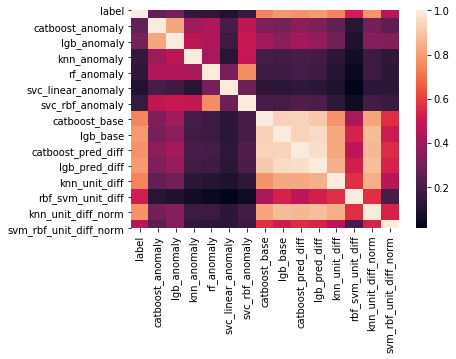

In [95]:
sns.heatmap(model_predictions_train.corr())

### Catboost

In [96]:
catboost_params = {
    'loss_function':'Logloss',
    'random_state':0,
    'early_stopping_rounds':50,
    'eval_metric':'F1'
}

In [97]:
submission_pool = Pool(data=model_predictions_test[features], cat_features=cat_features)

In [98]:
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
train_class = np.zeros(train_df.shape[0])
test_class = np.zeros(test_df.shape[0])
skf = StratifiedKFold(n_splits=3)
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:], train.iloc[test_index,:]
    y_train, y_test = y[train_index], y[test_index]
    train_pool = Pool(data=X_train, label=y_train,cat_features=cat_features)
    test_pool = Pool(data=X_test, label=y_test, cat_features=cat_features)    
    model = CatBoostClassifier(**catboost_params)
    model.fit(X=train_pool, eval_set=test_pool,verbose=10)
    train_preds[test_index] = model.predict_proba(test_pool)[:,1]
    train_class[test_index] = model.predict(test_pool)
    test_preds += model.predict_proba(submission_pool)[:,1]/3
    test_class = model.predict(submission_pool)
    validation_scores.append(f1_score(y_test,model.predict(test_pool),average='micro'))
test_class = np.where(test_class > 2, 1, 0)

Learning rate set to 0.058029
0:	learn: 0.9770407	test: 0.9760811	best: 0.9760811 (0)	total: 6.18ms	remaining: 6.18s
10:	learn: 0.9800993	test: 0.9791125	best: 0.9791125 (10)	total: 75.6ms	remaining: 6.8s
20:	learn: 0.9804337	test: 0.9787193	best: 0.9791948 (15)	total: 123ms	remaining: 5.74s
30:	learn: 0.9808248	test: 0.9787193	best: 0.9791948 (15)	total: 170ms	remaining: 5.31s
40:	learn: 0.9814485	test: 0.9787111	best: 0.9791948 (15)	total: 240ms	remaining: 5.61s
50:	learn: 0.9815939	test: 0.9785143	best: 0.9791948 (15)	total: 290ms	remaining: 5.39s
60:	learn: 0.9825136	test: 0.9781416	best: 0.9791948 (15)	total: 337ms	remaining: 5.19s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.9791947602
bestIteration = 15

Shrink model to first 16 iterations.
Learning rate set to 0.05803
0:	learn: 0.9784848	test: 0.9731998	best: 0.9731998 (0)	total: 22.7ms	remaining: 22.7s
10:	learn: 0.9802844	test: 0.9782567	best: 0.9782567 (10)	total: 72.4ms	remaining: 6.51s
20:	learn: 0.9

In [99]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.963387294142629, 0.002170269477725125, 0.9611398963730569)

### Extratrees

In [100]:
et_params = {
    'n_estimators':10,
    'max_depth':3,
    'random_state':0    
}

In [101]:
folds = 3
skf = StratifiedKFold(n_splits=folds)
train_preds = np.zeros(train_df.shape[0])
test_preds = np.zeros(test_df.shape[0])
validation_scores = []
for train_index, test_index in skf.split(train, y):
    X_train, X_test = train.iloc[train_index,:].values, train.iloc[test_index,:].values
    y_train, y_test = y[train_index], y[test_index]
    
    model = ExtraTreesClassifier(**et_params)
    model.fit(X_train, y_train)
    
    test_preds += model.predict(test.values) / 3
    train_preds[test_index] = model.predict(X_test)
    validation_scores.append(f1_score(y_test,model.predict(X_test),average='micro'))

In [102]:
np.mean(validation_scores), np.std(validation_scores), min(validation_scores)

(0.9601635833977783, 0.0033040077230587417, 0.957167530224525)